In [2]:
from meu_modelo import RegLinBayesiana
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
import jupyterthemes
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as RF
import warnings
from bayes_opt import BayesianOptimization
jupyterthemes.stylefx.set_nb_theme('grade3')


Sumário, Contextualização, descrição dos dados, detalhamento da metodologia, resultados.
Falar sobre Regressão Linear Bayesiana e sobre otimização, colocar figuras.

# Contextualização

#### Aprendizado de Máquina na área da saúde:

#### Problema abordado: 

* Estudos observacionais sugerem que baixas concentrações plasmáticas de retinol, beta-caroteno ou outros carotenóides podem estar associados a um maior risco de desenvolver cancer.

* Este estudo tem como objetivo investigar a relação entre características pessoais e fatores dietéticos e a concentração plasmática de retinol.


## Descrição dos dados Usados 

(https://www.openml.org/d/511)

 

**O conjunto de dados usado possui 315 entradas, 13 atributos preditores e 1 atributo alvo. Sendo os atributos Idade, Sexo e Fumante categóricos e os outros numéricos, inclusive o alvo.**


|**Descrição dos atributos**|
|-------------------------|
|AGE: Idade em anos (years)|
|SEX: Sexo (1=Masc, 2=Fem)|
|SMOKSTAT: Status de fumante (1=Nunca, 2=Ex-fumante, 3=Fumante)|
|QUETELET: IMC (PESO/(ALTURA^2))|
|VITUSE: Uso de vitamina (1=Sim, com frequência, 2=Yes, pouca frequência, 3=Não)|
|CALORIES: Calorias consumidas por dia.|
|FAT: Gramas de gordura consumidas por dia.|
|FIBER: Gramas de fibra consumidas por dia.|
|ALCOHOL: Quantidade de drinks alcoólicos consumidos por semana.|
|CHOLESTEROL: Coleterol consumido (mg por dia).|
|BETADIET: Betacaroteno na dieta consumido (mcg por dia).|
|RETDIET: Retinol na dieta consumido (mcg por dia)|
|BETAPLASMA: Plasma Betacaroteno (ng/ml)|
|RETPLASMA: Plasma Retinol (ng/ml) (ALVO)|

    

In [3]:
# Load data
plasma_retinol = fetch_openml(name='plasma_retinol',version = 1,as_frame=True)
X = plasma_retinol.data
y = plasma_retinol.target

In [4]:
X.head()

,AGE,SEX,SMOKSTAT,QUETELET,VITUSE,CALORIES,FAT,FIBER,ALCOHOL,CHOLESTEROL,BETADIET,RETDIET,BETAPLASMA
0,64.0,Female,Former,21.48380,Yes_fairly_often,1298.8,57.0,6.3,0.0,170.3,1945.0,890.0,200.0
1,76.0,Female,Never,23.87631,Yes_fairly_often,1032.5,50.1,15.8,0.0,75.8,2653.0,451.0,124.0
2,38.0,Female,Former,20.01080,Yes_not_often,2372.3,83.6,19.1,14.1,257.9,6321.0,660.0,328.0
3,40.0,Female,Former,25.14062,No,2449.5,97.5,26.5,0.5,332.6,1061.0,864.0,153.0
4,72.0,Female,Never,20.98504,Yes_fairly_often,1952.1,82.6,16.2,0.0,170.8,2863.0,1209.0,92.0


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   AGE          315 non-null    float64 
 1   SEX          315 non-null    category
 2   SMOKSTAT     315 non-null    category
 3   QUETELET     315 non-null    float64 
 4   VITUSE       315 non-null    category
 5   CALORIES     315 non-null    float64 
 6   FAT          315 non-null    float64 
 7   FIBER        315 non-null    float64 
 8   ALCOHOL      315 non-null    float64 
 9   CHOLESTEROL  315 non-null    float64 
 10  BETADIET     315 non-null    float64 
 11  RETDIET      315 non-null    float64 
 12  BETAPLASMA   315 non-null    float64 
dtypes: category(3), float64(10)
memory usage: 26.0 KB


In [6]:
X['SEX'].value_counts()

Female    273
Male       42
Name: SEX, dtype: int64

In [7]:
X['SMOKSTAT'].value_counts()   

Never             157
Former            115
Current_Smoker     43
Name: SMOKSTAT, dtype: int64

In [8]:
X['VITUSE'].value_counts()   

Yes_fairly_often    122
No                  111
Yes_not_often        82
Name: VITUSE, dtype: int64

In [9]:
cat = X.select_dtypes(include='category', exclude=None).columns.to_list()

In [10]:
num = X.select_dtypes(include='float', exclude=None).columns.to_list()

In [11]:
X_d = pd.get_dummies(X, columns=cat)

In [12]:
X_train, X_test, y_train , y_test = train_test_split(X_d, y, test_size = 0.3, random_state = 13)

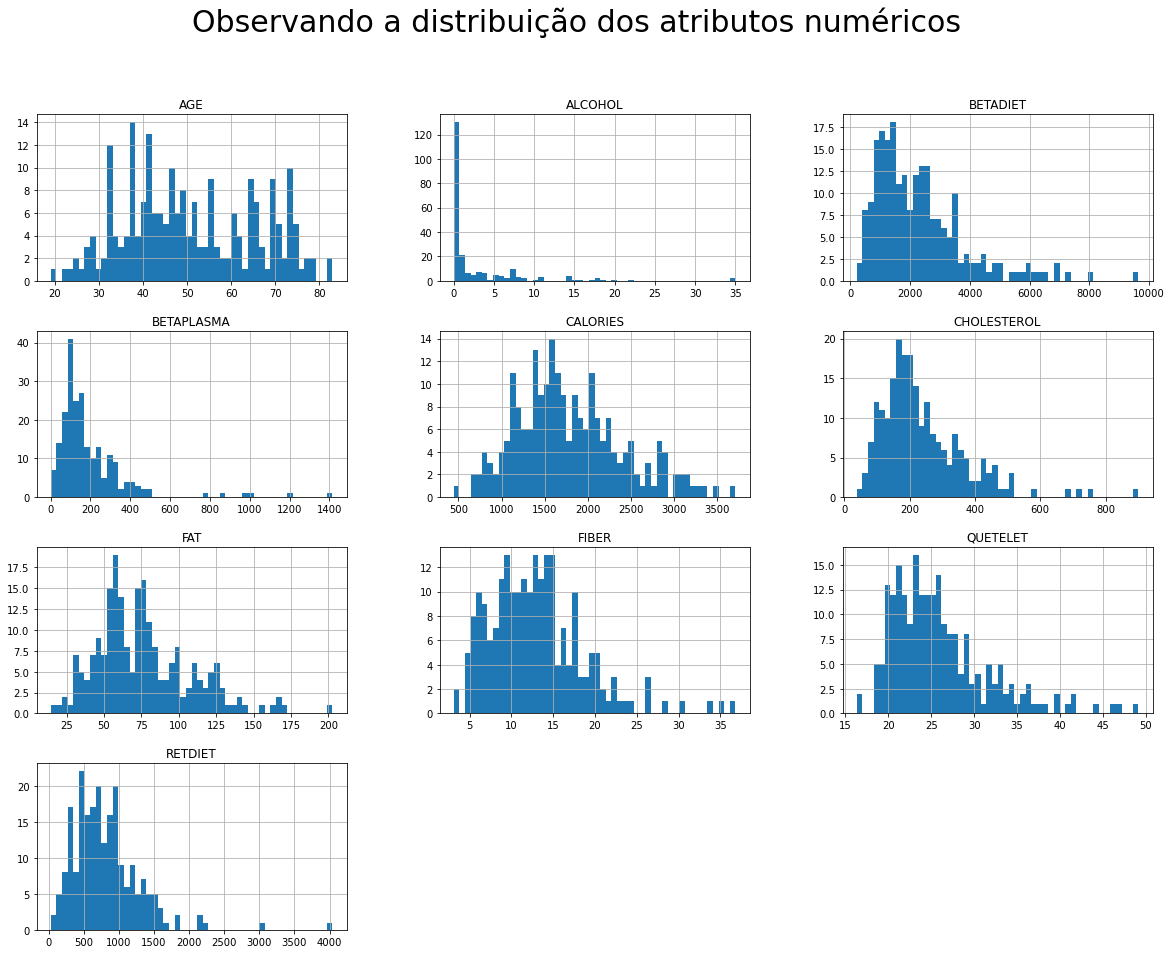

In [13]:
X_train[num].hist(bins=50,figsize = (20,15))
plt.suptitle('Observando a distribuição dos atributos numéricos',size=30)
plt.show()

In [14]:
#Removendo outliers
print("Os dados de treino tem {} entradas antes da remoção.".format(len(X_train)))
for col in num:
    mean = X_train[col].mean()
    std = X_train[col].std()
    cut = mean + 4*std
    X_train = X_train[X_train[col] < cut]

print("Os dados de treino tem {} entradas após a remoção.".format(len(X_train)))

y_train = y_train[X_train.index]
    

Os dados de treino tem 220 entradas antes da remoção.
Os dados de treino tem 210 entradas após a remoção.


In [15]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = RegLinBayesiana(alpha=47.46 ,beta=10.9)
model.fit(X_train, y_train)
y_mean, y_std = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_mean))
print(rmse)

297.9435527756799


In [16]:
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()
model1.fit(X_train, y_train)
y_pred= model1.predict(X_test)
rmse1 = np.sqrt(mean_squared_error(y_pred,y_test))
print(rmse1)

298.16326506843944


## Otimização bayesiana de Random Forest

In [16]:
def rf_cv(n_estimators, min_samples_split, max_features, data, targets):
    """Random Forest cross validation.
    This function will instantiate a random forest classifier with parameters
    n_estimators, min_samples_split, and max_features. Combined with data and
    targets this will in turn be used to perform cross validation. The result
    of cross validation is returned.
    Our goal is to find combinations of n_estimators, min_samples_split, and
    max_features that minimzes the log loss.
    """
    estimator = RF(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        max_features=max_features,
        random_state=2
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring='neg_root_mean_squared_error', cv=4)
    return cval.mean()

In [17]:
def optimize_rf(data, targets):
    """Apply Bayesian Optimization to Random Forest parameters."""
    def rf_crossval(n_estimators, min_samples_split, max_features):
        """Wrapper of RandomForest cross validation.
        Notice how we ensure n_estimators and min_samples_split are casted
        to integer before we pass them along. Moreover, to avoid max_features
        taking values outside the (0, 1) range, we also ensure it is capped
        accordingly.
        """
        return rf_cv(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.999), 1e-3),
            
            
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=rf_crossval,
        pbounds={
            "n_estimators": (10, 500),
            "min_samples_split": (2, 25),
            "max_features": (0.1, 0.999)
            
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=100,init_points=3)
    return optimizer
    


In [18]:
a = optimize_rf(X_train,y_train)

|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -195.3    |  0.2722   |  16.31    |  224.5    |
|  2        | -198.1    |  0.806    |  19.94    |  143.6    |
|  3        | -195.8    |  0.3485   |  20.44    |  479.5    |
|  4        | -198.4    |  0.7304   |  15.38    |  225.4    |
|  5        | -198.6    |  0.9241   |  16.19    |  153.1    |
|  6        | -198.2    |  0.8985   |  23.55    |  139.7    |
|  7        | -198.1    |  0.3412   |  4.032    |  97.03    |
|  8        | -194.7    |  0.1913   |  20.42    |  479.7    |
|  9        | -199.0    |  0.8429   |  16.24    |  224.9    |
|  10       | -200.7    |  0.7674   |  5.795    |  396.0    |
|  11       | -194.6    |  0.197    |  16.07    |  224.1    |
|  12       | -197.6    |  0.655    |  16.37    |  223.9    |
|  13       | -198.0    |  0.4881   |  15.32    |  328.9    |
|  14       | -197.7    |  0.5851   |  21.77    |  273.1    |
|  15   

|  80       | -195.0    |  0.1367   |  23.88    |  479.8    |
|  81       | -197.8    |  0.834    |  24.77    |  479.8    |
|  82       | -194.7    |  0.1537   |  15.1     |  224.1    |
|  83       | -195.6    |  0.2707   |  23.75    |  481.0    |
|  84       | -195.8    |  0.3317   |  22.59    |  481.9    |
|  85       | -194.7    |  0.3096   |  14.38    |  225.2    |
|  86       | -194.2    |  0.1412   |  13.6     |  225.9    |
|  87       | -199.5    |  0.9055   |  13.81    |  226.2    |
|  88       | -194.1    |  0.1078   |  13.15    |  225.4    |
|  89       | -200.1    |  0.9545   |  12.74    |  225.4    |
|  90       | -194.9    |  0.1393   |  24.78    |  480.9    |
|  91       | -194.9    |  0.1173   |  21.48    |  482.9    |
|  92       | -194.2    |  0.1188   |  13.59    |  225.3    |
|  93       | -195.6    |  0.2461   |  20.97    |  483.7    |
|  94       | -196.6    |  0.4688   |  22.63    |  483.2    |
|  95       | -197.1    |  0.5205   |  21.43    |  484.6    |
|  96   

In [19]:
a.max['params']

{'max_features': 0.10591757131837501,
 'min_samples_split': 14.564314007320878,
 'n_estimators': 223.73586143208775}

In [17]:
#Random Forest sem otimização
modelo1 = RF()
modelo1.fit(X_train, y_train)
y_pred = modelo1.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
rmse


225.49468504647848

In [21]:
max_features = a.max['params']['max_features']
min_samples_split = a.max['params']['min_samples_split']
n_estimators = a.max['params']['n_estimators']

In [22]:
modelo = RF(max_features=max_features,min_samples_split=int(min_samples_split),n_estimators=int(n_estimators))

In [23]:
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
rmse

215.3337490125917